This is to test the model after correcting update_f_cross_pop.

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=130);
# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import glob
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import hierarchical_model_generator
import hierarchical_sampling_model
import samples

In [2]:
import pandas as pd
print('pd', pd.__version__)
import allensdk
print('allensdk', allensdk.__version__)
import h5py
print('h5py', h5py.__version__)
import pynwb
print('pynwb', pynwb.__version__)
import hdmf
print('hdmf', hdmf.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0


# Hierarchical model Generator

### Load tamplate model

In [6]:
model_files = [
'HBM_checkpoint_B_MC_0_500ms_probeCE_condition1_20200813-092937_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCE_o225_270_f8_20200801-174224_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCDE_o225_270_f8_20200731-125456_generator_template.pkl',
'798911424_checkpoints_batch5_20201111-121627_generator_template.pkl', # B A3
'798911424_checkpoints_batch14_20201023-042306_generator_template.pkl']  # BSS A3

In [ ]:
# def runner(random_seed):
random_seed = 0

print(f'---------------------- {random_seed} --------------------')
## Load simulation
generator_model = hierarchical_model_generator.HierarchicalModelGenerator()
data_folder = project_dir + 'Output/simulation/'
file_path = (data_folder + model_files[4])
generator_model.load_model(file_path)

np.random.seed(random_seed)  # Random seed for pseudo data.
model_feature_type = 'BSS'
generator_model.initial_step(model_feature_type=model_feature_type, num_trials=180, num_conditions = 1)

# Load samples. Only used for lambda variations.
# generator_model.samples = samples.Samples()
# load_dir = project_dir + 'Output/simulation/BSS_A3_R180_samples/'
# generator_model.samples.load_batches(load_dir, start_id=6, end_id=10, thin_step=1)

## Generate data
select_clist = [4]
generator_model.generate_mu_sigma(sample_type='fixed', verbose=False)
generator_model.generate_q()
generator_model.generate_f_pop_gac(select_clist=select_clist, same_as_cross=False, verbose=False)
generator_model.generate_z(verbose=False)
generator_model.generate_p_gac(verbose=False)
generator_model.generate_log_lambda_nargc(variation='none', laplacian_scalar=1, verbose=False)
generator_model.generate_spikes(verbose=False)

## Prepare for the data fitting.
trial_time_window=generator_model.trial_time_window
spike_train_time_line = generator_model.spike_train_time_line
spike_trains, spike_times = generator_model.spike_trains, generator_model.spike_times
session = None
spike_counts, spike_shifts = generator_model.spike_counts, generator_model.spike_shifts
units_probes = generator_model.selected_units['probe_description']
probes = generator_model.probes
selected_units = generator_model.selected_units
trials_indices = generator_model.trials_indices
trials_groups = generator_model.trials_groups

## Initial HBM
np.random.seed(0)  # Random seed for MCMC chain.
model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups,
                   trial_time_window, probes=['probeC', 'probeD', 'probeE'], num_areas=3, num_groups=3, 
                   model_feature_type='BSS', prior_type='diag',
                   eta_smooth_tuning=3e-8, verbose=False)
# Initialize with true values.
model.set_model(generator_model, select_clist=select_clist)

clist = [0]; thin_begin = 0; thin_step = 1
t = tqdm(range(0, 2000), ncols=100, file=sys.stdout)  # t = trange(0, 2000)
for itr in t:
    slc = (itr >= thin_begin) and (itr % thin_step == 0)
    for c in clist:
        if itr < 5:
            model.update_f_local_pop_cag(c, sample_type='fit', verbose=False)
            model.update_f_cross_pop_ca_2(c, sample_type='fit', record=(c==clist[-1] and slc), verbose=False)
        if itr > 5:
            model.update_f_local_pop_cag(c, sample_type='sample', verbose=False)
            model.update_f_cross_pop_ca_2(c, sample_type='sample', record=(c==clist[-1] and slc), verbose=False)
        model.update_q_arc(c, sample_type='sample', proposal_scalar=0.02, fit_peak_ratio=0,
                           record=(c==clist[-1] and slc), verbose=False)  # proposal_scalar=0.1 BA2  0.04 BSS A3
        if itr > 150 and itr % 10 == 0:
            model.update_z_ngac(c, sample_type='sample', record=(c==clist[-1]), verbose=False)
        if itr > 150:
            model.update_p_gac(c, sample_type='sample', record=(c==clist[-1] and slc), verbose=False)
    if itr > 150:
        model.update_mu_simga(clist=clist, sample_type='iw_sample', record=slc, verbose=False)
    model.complete_log_likelihood(clist)
    t.set_description(f'{model.samples.log_likelihood[-1]:.2f} | {model.samples.q_accept_ratio_mean:.3f}')

## Output
model.samples.plot_log_likelihood()
error_rnd, error_hat, error_fix, CI_trap_rnd, CI_trap_hat, CI_trap_fix = model.samples.rho_mse_ci_coverage(
    burn_in=0, end=None, step=1, rho_type=['marginal', 'corrcoef'], true_model=generator_model, 
    model_feature_type=model.model_feature_type, verbose=True)
# print(CI_trap_hat)
print(CI_trap_rnd)
print(CI_trap_fix)
_=model.samples.plot_marginal_correlation(0, 1, burn_in=0, end=None, step=1, plot_type='rho',
        true_model=generator_model, model_feature_type=model.model_feature_type, distribution_type='hist')
_=model.samples.plot_partial_correlation(0, 1, burn_in=1000, end=None, step=1, plot_type='rho',
        true_model=generator_model, model_feature_type=model.model_feature_type, distribution_type='hist')

# Save data.
experiment_name = f'{model_feature_type}_0_500ms_probe3_R{len(trials_indices)}_'
timestr = time.strftime("%Y%m%d-%H%M%S")
output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_diag_prior_fixed_sigma_df10_fpop2/'

# Save estimated model.
prefix = f'HBM_checkpoint_seed{random_seed}_'
file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
model.save_model(save_data=False, file_path=file_path)
# Save true model.
prefix = f'HBM_generator_seed{random_seed}_'
file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
generator_model.save_data(save_spikes=False, file_path=file_path)
# Save samples.
prefix = f'HBM_samples_seed{random_seed}_'
file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
model.samples.save(file_path)

#### Unit Test

In [181]:
# def runner(random_seed):
random_seed = 0

print(f'---------------------- {random_seed} --------------------')
## Load simulation
generator_model = hierarchical_model_generator.HierarchicalModelGenerator()
data_folder = project_dir + 'Output/simulation/'
file_path = (data_folder + model_files[4])
generator_model.load_model(file_path)

np.random.seed(random_seed)  # Random seed for pseudo data.
model_feature_type = 'BSS'
generator_model.initial_step(model_feature_type=model_feature_type, num_trials=60, num_conditions = 1)

# Load samples. Only used for lambda variations.
# generator_model.samples = samples.Samples()
# load_dir = project_dir + 'Output/simulation/BSS_A3_R180_samples/'
# generator_model.samples.load_batches(load_dir, start_id=6, end_id=10, thin_step=1)

## Generate data
select_clist = [4]
generator_model.generate_mu_sigma(sample_type='fixed', verbose=False)
generator_model.generate_q()
generator_model.generate_f_pop_gac(select_clist=select_clist, same_as_cross=False, verbose=False)
generator_model.generate_z(verbose=False)
generator_model.generate_p_gac(verbose=False)
generator_model.generate_log_lambda_nargc(variation='none', laplacian_scalar=1, verbose=False)
generator_model.generate_spikes(verbose=False)

## Prepare for the data fitting.
trial_time_window=generator_model.trial_time_window
spike_train_time_line = generator_model.spike_train_time_line
spike_trains, spike_times = generator_model.spike_trains, generator_model.spike_times
session = None
spike_counts, spike_shifts = generator_model.spike_counts, generator_model.spike_shifts
units_probes = generator_model.selected_units['probe_description']
probes = generator_model.probes
selected_units = generator_model.selected_units
trials_indices = generator_model.trials_indices
trials_groups = generator_model.trials_groups


---------------------- 0 --------------------
model_feature_type: BSS

num areas 3   num trials 60   num conditions 1   num qs 3


In [203]:
## Initial HBM
np.random.seed(0)  # Random seed for MCMC chain.
model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups,
                   trial_time_window, probes=['probeC', 'probeD', 'probeE'], num_areas=3, num_groups=3, 
                   model_feature_type='BSS', prior_type='diag', eta_smooth_tuning=3e-8, verbose=False)
# Initialize with true values.
# model.set_model(generator_model, select_clist=select_clist)
model.sub_group_df_c = generator_model.sub_group_df_c

clist = [0]; thin_begin = 0; thin_step = 1
t = tqdm(range(0, 3000), ncols=100, file=sys.stdout)
for itr in t:
    slc = (itr >= thin_begin) and (itr % thin_step == 0)
    for c in clist:
        if itr < 40:
            model.update_f_cross_pop_ca_2(c, sample_type='fit', record=(c==clist[-1]), verbose=False)
        elif itr >= 40:
            model.update_f_cross_pop_ca_2(c, sample_type='sample', record=(c==clist[-1] and slc), verbose=False)

        if itr < 10:
            model.update_q_arc(c, sample_type='fit', fit_peak_ratio=0,
                               record=(c==clist[-1]), verbose=False)
        elif (itr >= 10) and (itr < 40):  # Fit with peak.
            model.update_q_arc(c, sample_type='fit', fit_peak_ratio=0.05, 
                               record=(c==clist[-1]), verbose=False)
        elif (itr >= 40):
            model.update_q_arc(c, sample_type='sample', proposal_scalar=0.03, 
                               fit_peak_ratio=max(0, 0.01-0.01/2000*itr), record=(c==clist[-1]), verbose=False)
    if itr > 50:
        model.update_mu_simga(clist=clist, sample_type='iw_sample', record=slc, verbose=False)
    model.complete_log_likelihood(clist)
    t.set_description(f'{model.samples.log_likelihood[-1]:.1f} |q {model.samples.q_accept_ratio_mean:.3f} '+
                      f'|f {model.samples.f_cross_pop_accept_ratio:.3f}')


Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[43 27 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  
-2785654.8 |q 0.188 |f 0.268: 100%|█████████████████████████████| 3000/3000 [55:45<00:00,  1.12s/it]


## Check output.

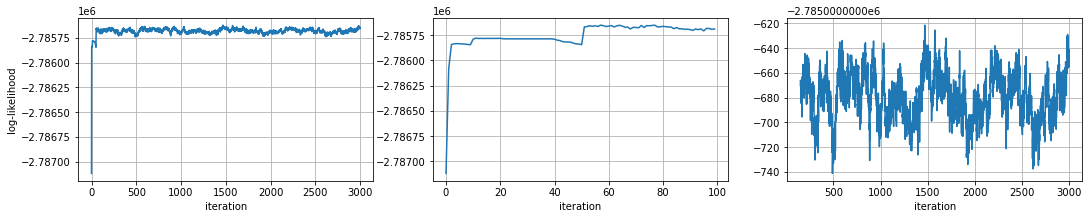

In [204]:
model.samples.plot_log_likelihood()

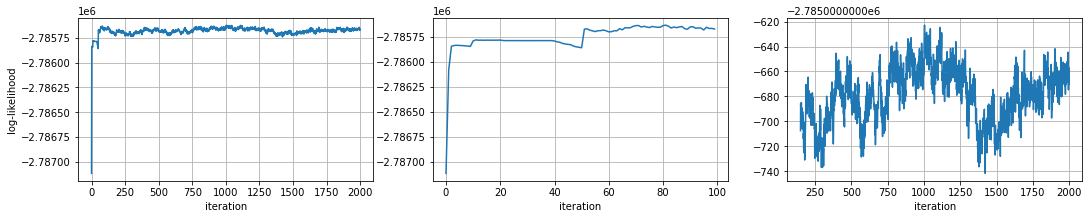

f_samples.shape: (125, 1, 3, 3, 250)
accept ratio: 0.2679054054054054 2379 8880


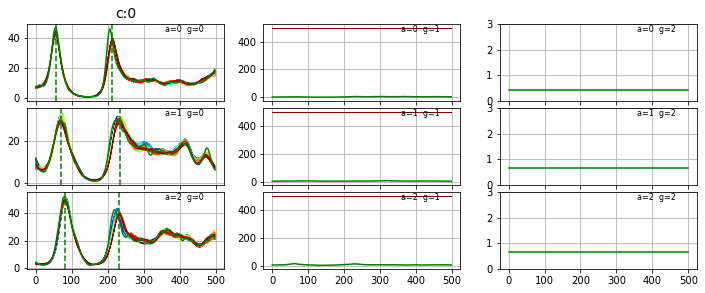

In [205]:
model.samples.plot_f_pop_rainbow([0], spike_train_time_line, burn_in=500, end=None, step=20,
    f_pop_cag_ref=generator_model.f_pop_cag, f_peak1_ac_ref=model.f_peak1_ac, f_peak2_ac_ref=model.f_peak2_ac)

f_samples.shape: (75, 1, 3, 3, 250)
accept ratio: 0.2612244897959184 1536 5880


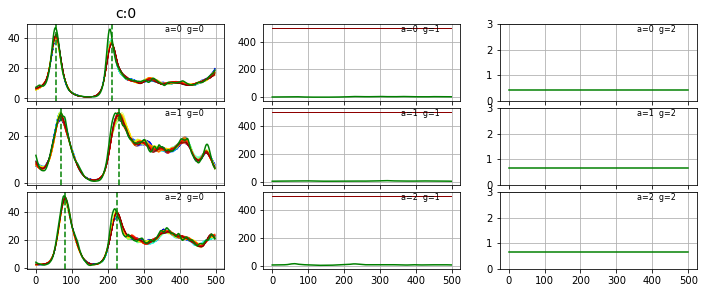

f_samples.shape: (75, 1, 3, 3, 250)
accept ratio: 0.251530612244898 1479 5880


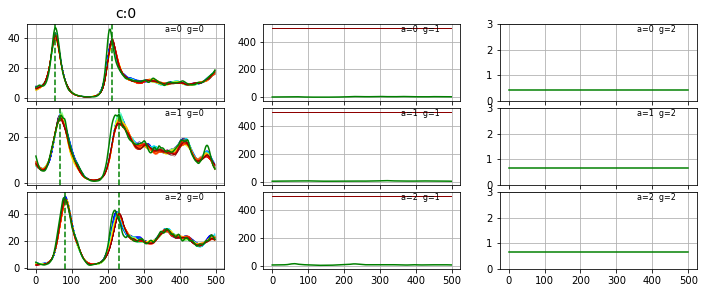

f_samples.shape: (92, 1, 3, 3, 250)
accept ratio: 0.2571810287241149 3850 14970


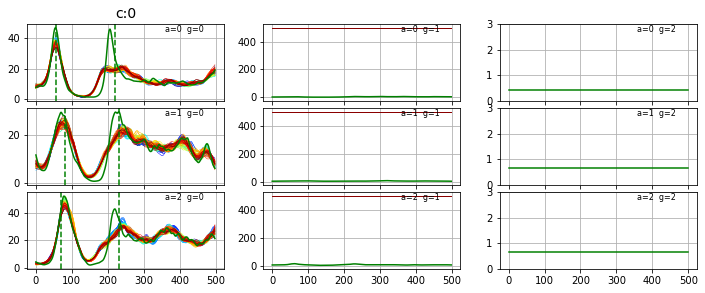

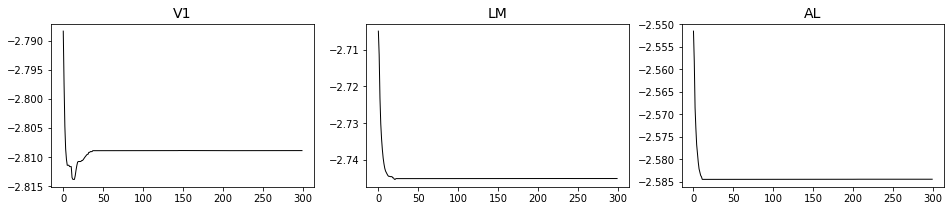

In [206]:
model.samples.plot_f_pop_baseline(clist, burn_in=0,end=None,step=10)

Estimated corr:0.632  p-value:5.919e-08
Accept ratio: 0.20651360544217687 min: 0.0 max: 0.37755102040816324
num_qs: 60
q_samples.shape:  (2000, 3, 60, 1)
sub q shape: (1, 2000, 60)
Area 0
mean [0.01006875]
std  [0.19209248]
mean/std [0.05241614]


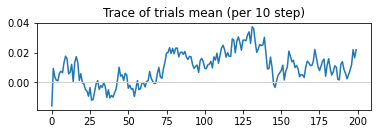

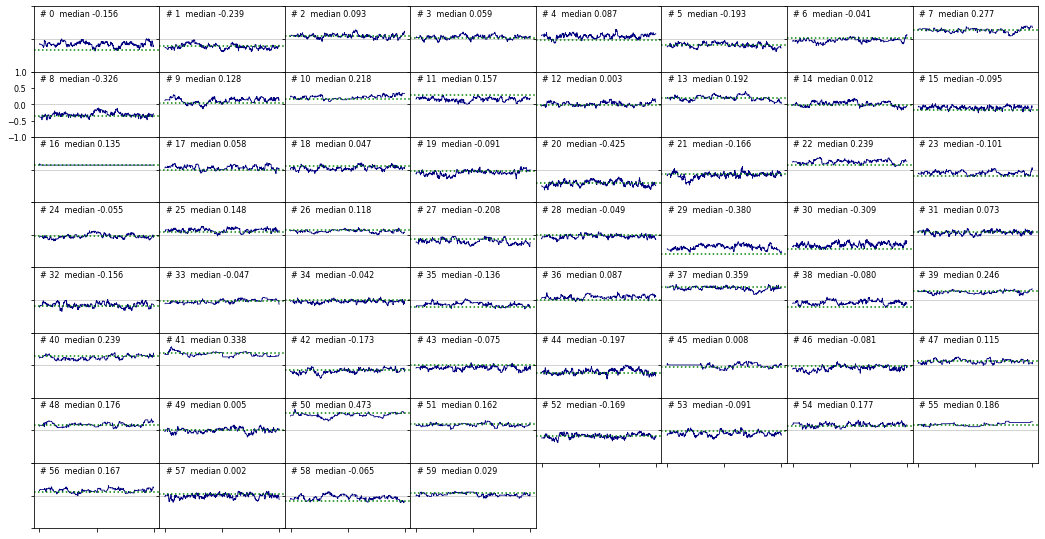

sub q shape: (1, 2000, 60)
Area 1
mean [0.02806988]
std  [0.38234907]
mean/std [0.07341428]


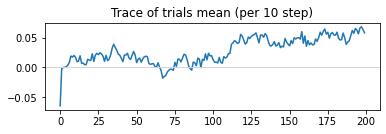

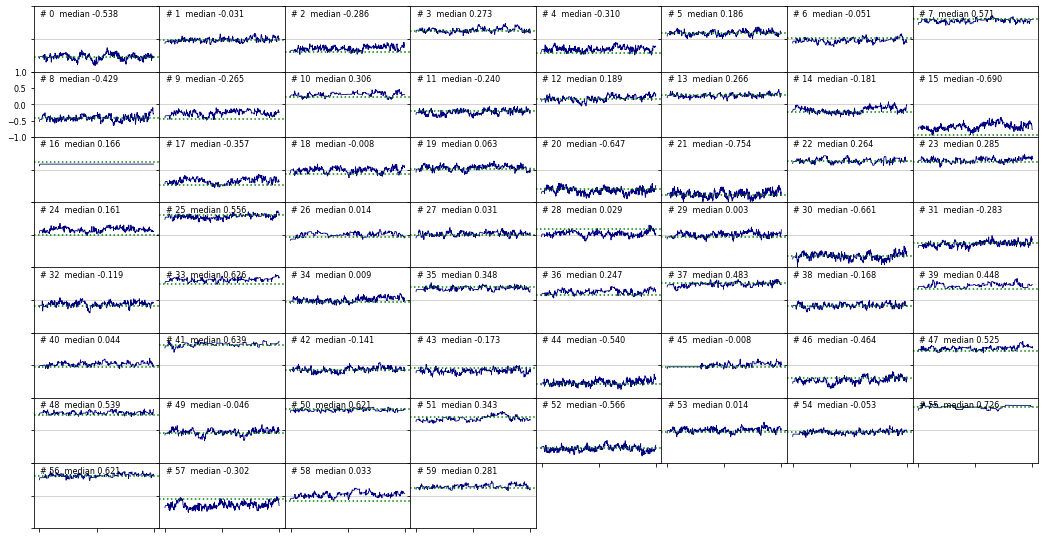

sub q shape: (1, 2000, 60)
Area 2
mean [-0.00920365]
std  [0.32503304]
mean/std [-0.02831605]


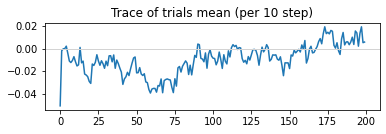

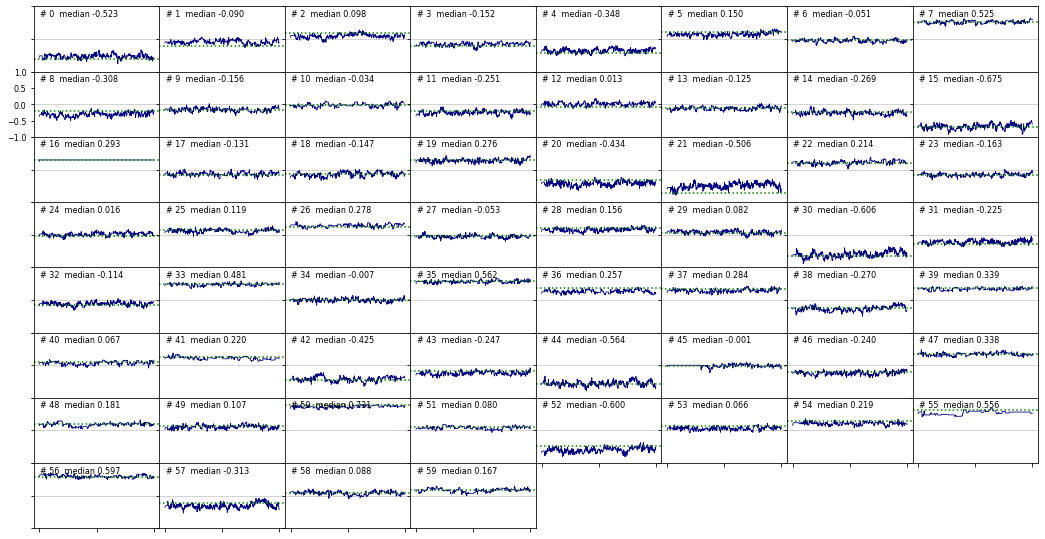

In [192]:
model.samples.plot_q_arc([0], burn_in=0, end=None, option='q', q_arc_ref=generator_model.q_arc)


Estimated corr:0.689  p-value:1.177e-09
Accept ratio: 0.18824324324324326 min: 0.0 max: 0.3368243243243243
num_qs: 60
q_samples.shape:  (3000, 3, 60, 1)
sub q shape: (1, 3000, 60)
Area 0
mean [-0.00530837]
std  [0.03497751]
mean/std [-0.15176526]


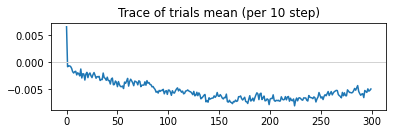

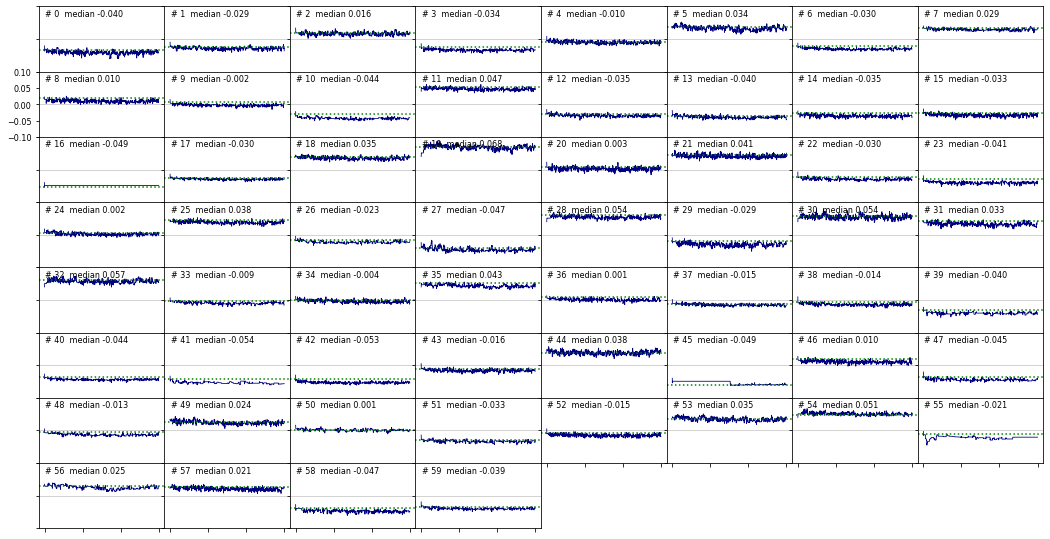

sub q shape: (1, 3000, 60)
Area 1
mean [-0.00575029]
std  [0.03824897]
mean/std [-0.15033837]


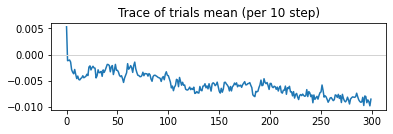

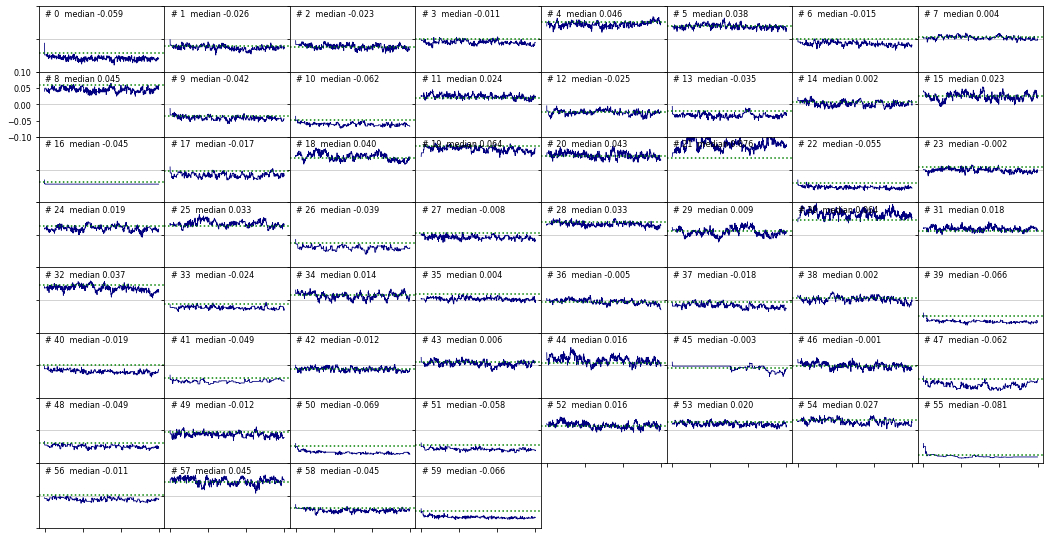

sub q shape: (1, 3000, 60)
Area 2
mean [-0.00759805]
std  [0.03966546]
mean/std [-0.19155332]


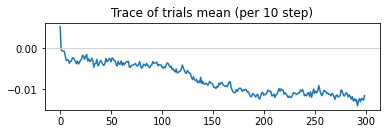

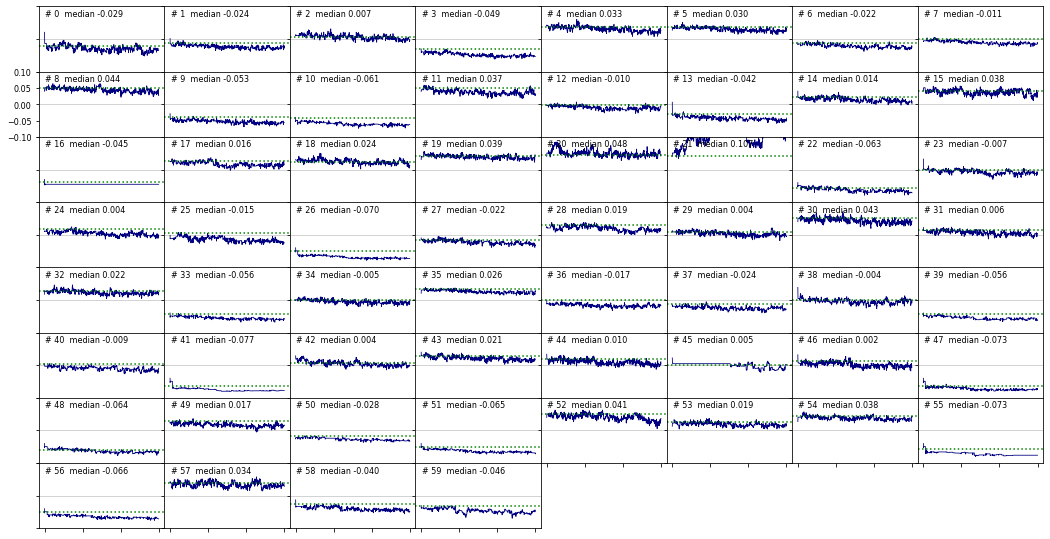

In [207]:
model.samples.plot_q_arc([0], burn_in=0, option='q_shift2', q_shift2_arc_ref=generator_model.q_shift2_arc, ylim=[-0.1, 0.1])


Estimated corr:0.686  p-value:1.419e-09
Accept ratio: 0.2163265306122449 min: 0.0 max: 0.3826530612244898
num_qs: 60
q_samples.shape:  (2000, 3, 60, 1)
sub q shape: (1, 2000, 60)
Area 0
mean [-0.00172233]
std  [0.03524214]
mean/std [-0.04887125]


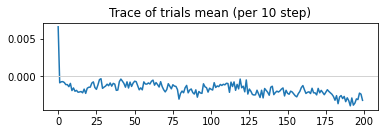

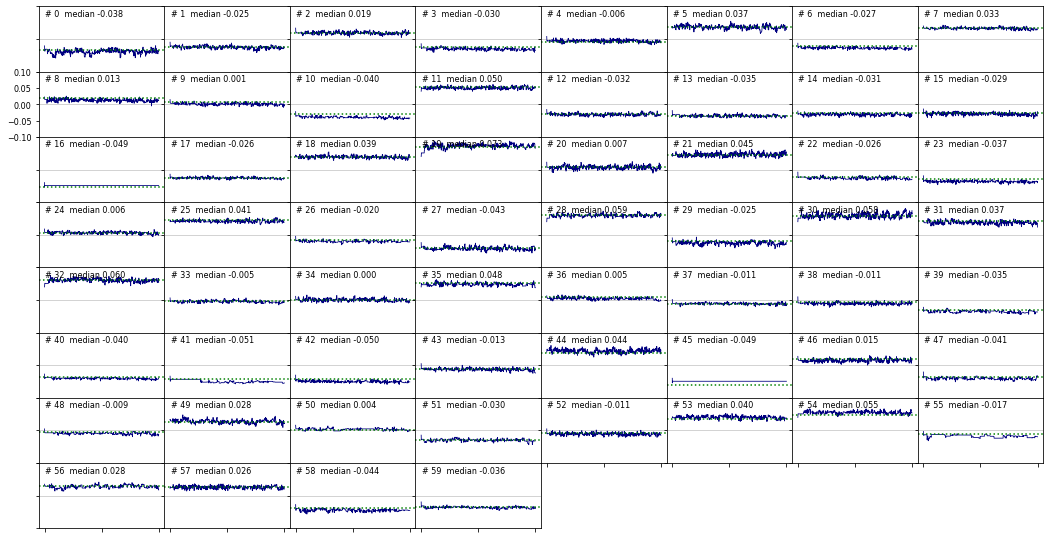

sub q shape: (1, 2000, 60)
Area 1
mean [-0.00249546]
std  [0.0389834]
mean/std [-0.06401351]


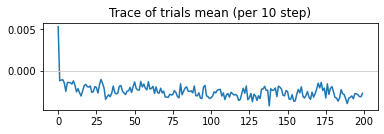

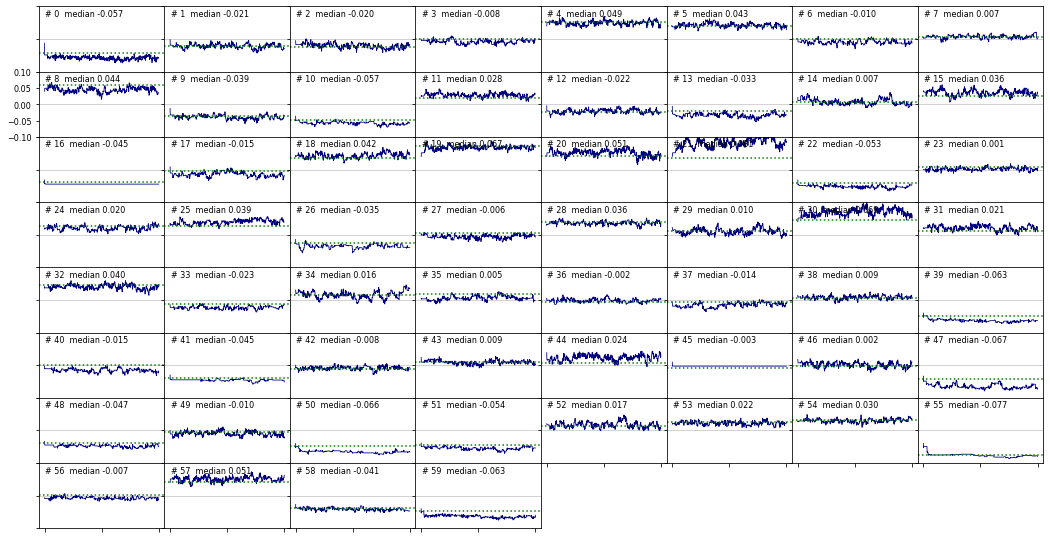

sub q shape: (1, 2000, 60)
Area 2
mean [-0.00262179]
std  [0.03984745]
mean/std [-0.06579575]


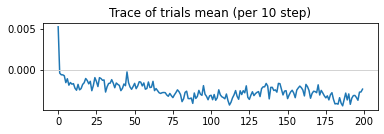

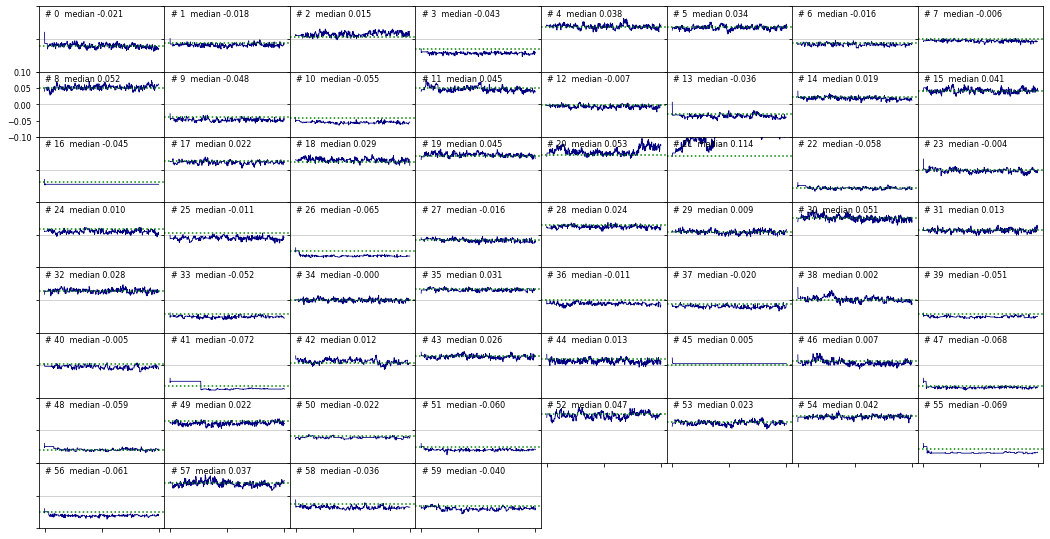

In [ ]:
model.samples.plot_q_arc([0], burn_in=0, end=None, option='q_shift1', q_shift1_arc_ref=generator_model.q_shift1_arc)


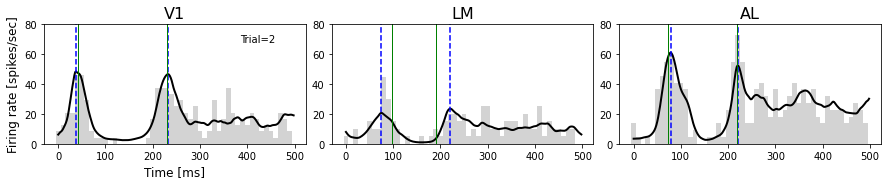

In [167]:
# model.plot_group_activity_per_trial_demo(c=0, r=27, true_model=generator_model, output_dir=None)
# model.plot_group_activity_per_trial_demo(c=0, r=43, true_model=generator_model, output_dir=None)
model.plot_group_activity_per_trial_demo(c=0, r=2, true_model=generator_model, output_dir=None)

sigma_samples.shape: (2990, 9, 9)
rho_samples.shape: (2990, 9, 9)


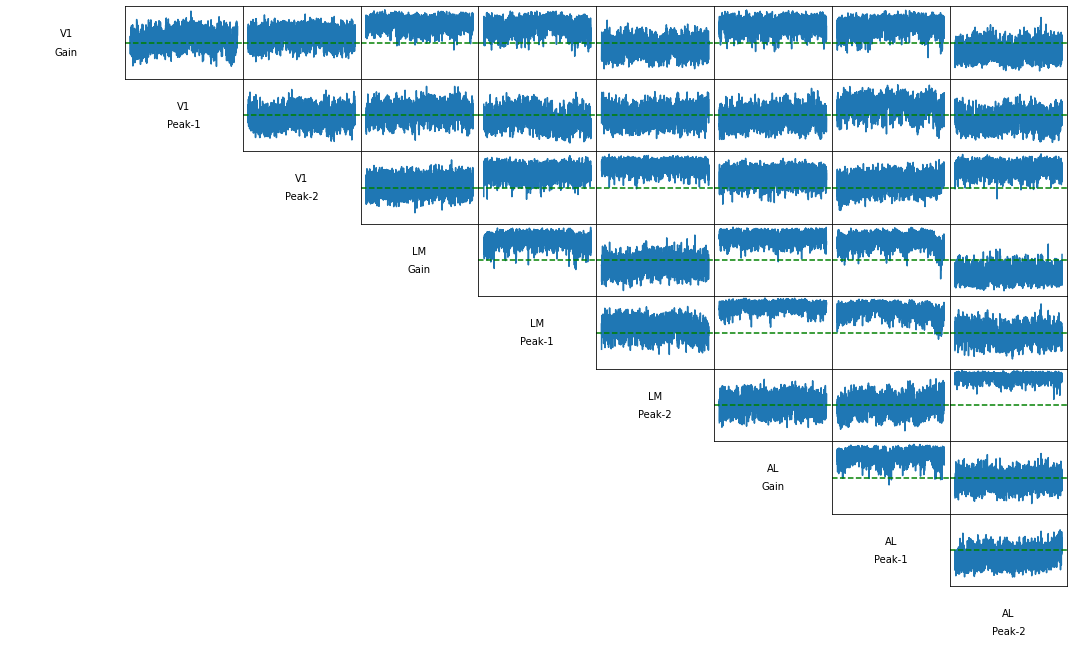

In [149]:
partial_adj = model.samples.plot_correlation_traces(rho_type='marginal')

sigma_samples.shape: (1949, 9, 9)


D:/Brain_Network/Code\util.py:547: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:547: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


CI traps hat total, ratio: 36.0 1.0
CI traps true total, ratio: 35.0 0.9722222222222222


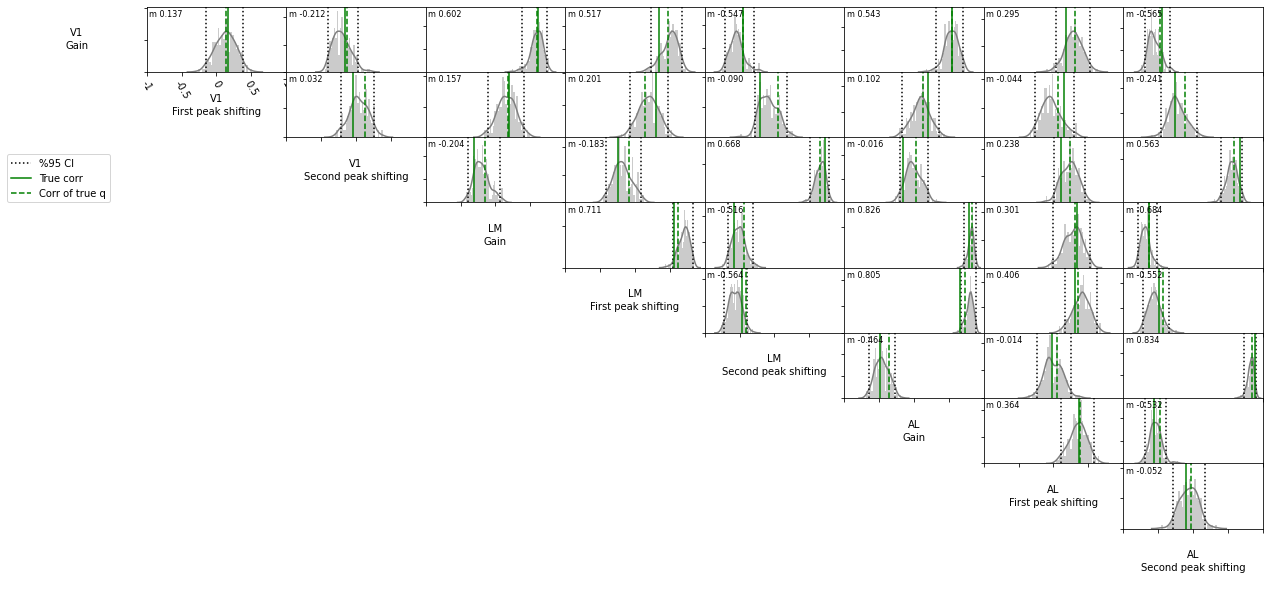

In [200]:
_=model.samples.plot_marginal_correlation(0, 1, burn_in=100, end=None, step=10, plot_type='rho',
        true_model=generator_model, model_feature_type=model.model_feature_type, distribution_type='hist')

sigma_samples.shape: (1949, 9, 9)


D:/Brain_Network/Code\util.py:547: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:547: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


CI traps hat total, ratio: 36.0 1.0
CI traps true total, ratio: 36.0 1.0


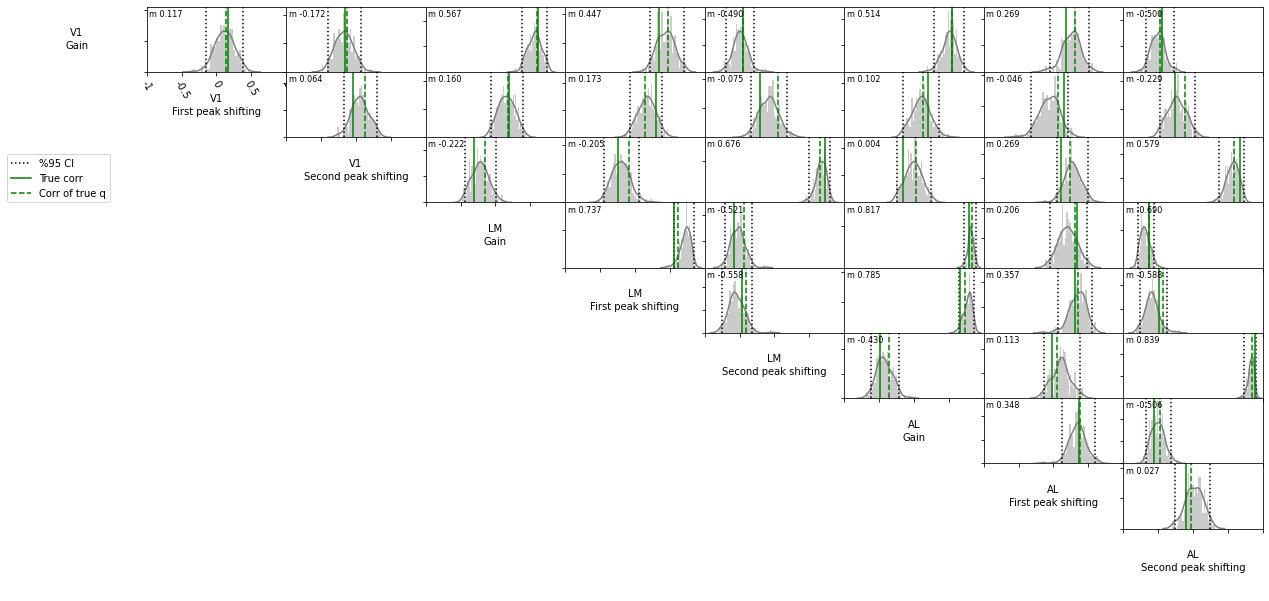

sigma_samples.shape: (1, 9, 9)
rho_samples.shape: (1, 9, 9)


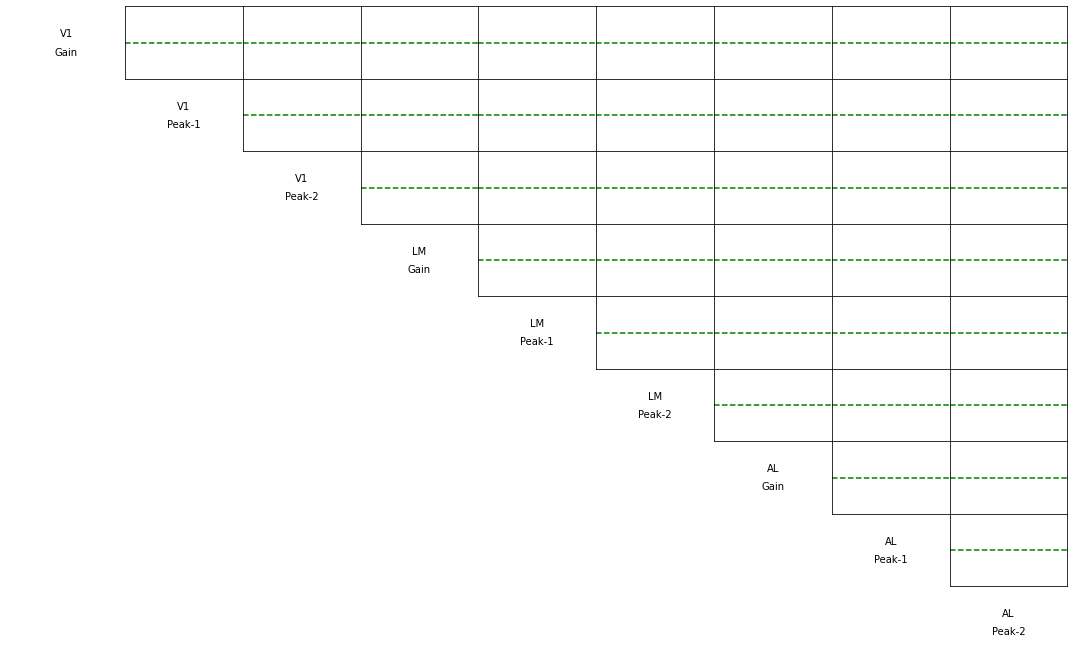

In [158]:
model.samples.plot_correlation_traces(rho_type='partial')

sigma_samples.shape: (1949, 9, 9)
rho_samples.shape: (145, 9, 9)


D:/Brain_Network/Code\util.py:547: RuntimeWarning: divide by zero encountered in log
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:547: RuntimeWarning: invalid value encountered in log
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:547: RuntimeWarning: divide by zero encountered in log
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:547: RuntimeWarning: invalid value encountered in log
  z = 0.5 * np.log((1 + rho) / (1 - rho))


CI traps hat total, ratio: 36.0 1.0
CI traps true total, ratio: 32.0 0.8888888888888888


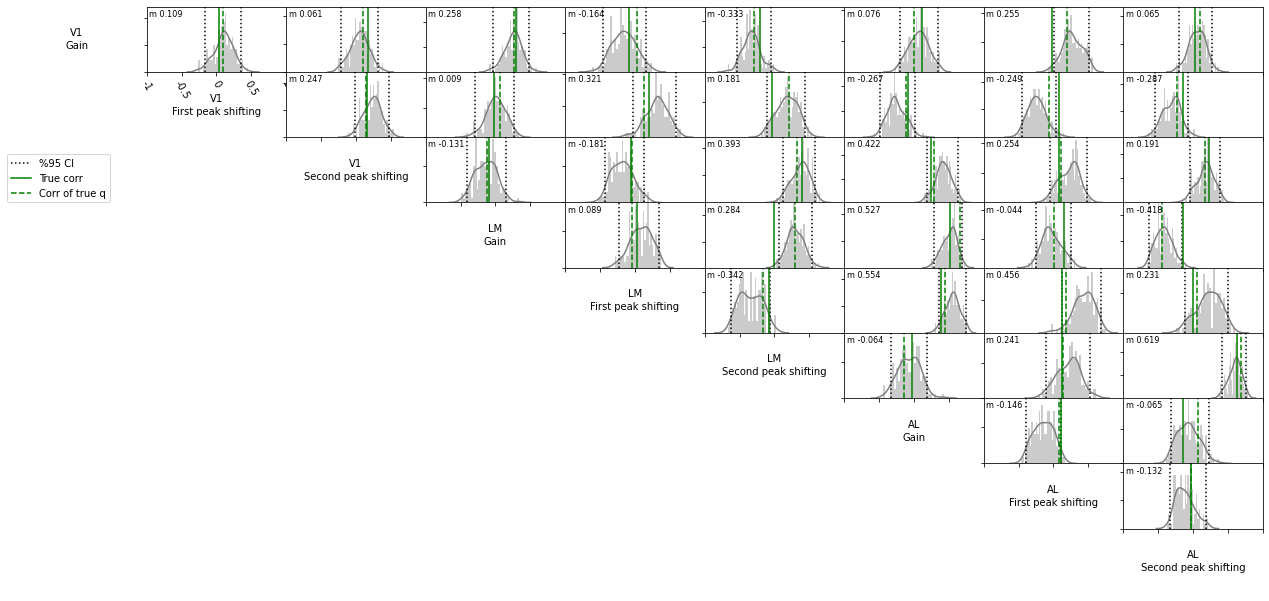

In [201]:
_=model.samples.plot_partial_correlation(0, 1, burn_in=500, end=None, step=10, plot_type='rho',
        true_model=generator_model, model_feature_type=model.model_feature_type, distribution_type='hist')

sigma_samples.shape: (1949, 9, 9)
rho_samples.shape: (145, 9, 9)


D:/Brain_Network/Code\util.py:547: RuntimeWarning: divide by zero encountered in log
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:547: RuntimeWarning: invalid value encountered in log
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:547: RuntimeWarning: divide by zero encountered in log
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:547: RuntimeWarning: invalid value encountered in log
  z = 0.5 * np.log((1 + rho) / (1 - rho))


CI traps hat total, ratio: 36.0 1.0
CI traps true total, ratio: 30.0 0.8333333333333334


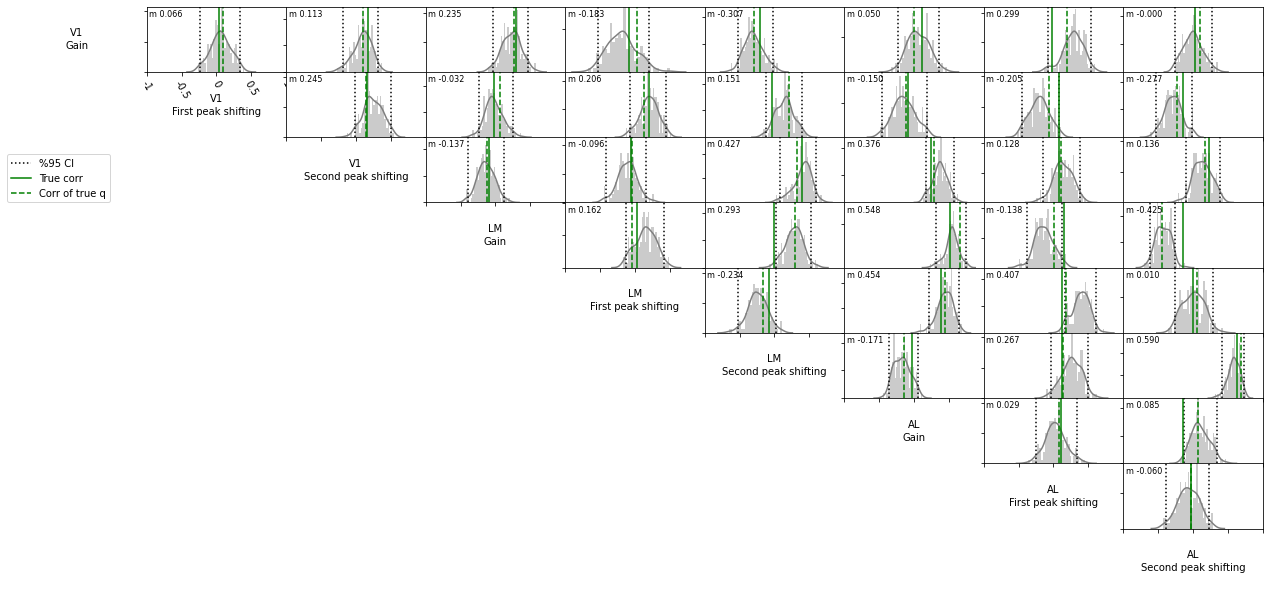

### KS test

In [57]:
model.samples.peek()

f_pop:2000  f_pop_beta:2000  q:2001  q_shift1:2001  q_shift2:2001  f_warp_sources:2001  f_warp_targets:2001  mu_cross_pop:1800  sigma_cross_pop:1800  rho_cross_pop_simple:1799  z:179  p:1800  log_likelihood:2000  


In [46]:
clist = [0]
z_c = model.samples.get_z_mode(burn_in=600, end=None, step=1, sub_group_df_c=model.sub_group_df_c)
lambda_garc = model.samples.get_lambda_garc(clist, spike_train_time_line, model_feature_type=model.model_feature_type,
        burn_in=600, end=None, step=1, samples_aligned='end', verbose=False)

sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)


In [50]:
model.ks_test(clist, lambda_garc, z_c, test_size=0.001, null_type='sampling', num_null_samples=1000, correction=None)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:14<00:00, 134.27s/it]

CI cnt 261  CI trap ratio 0.6436781609195402
zero neuron:2


In [51]:
model.ks_test(clist, lambda_garc, z_c, test_size=0.05, null_type='sampling', num_null_samples=1000, correction=None)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:15<00:00, 135.52s/it]

CI cnt 261  CI trap ratio 0.4482758620689655
zero neuron:2


In [55]:
model.ks_test_CI_cnt
model.ks_test_CI_trap_cnt

{0.001: 168, 0.05: 117}

In [48]:
# Laplacian scalar 20, alpha=0.001

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.56s/it]

CI cnt 261  CI trap ratio 0.6628352490421456
zero neuron:2


In [47]:
# Laplacian scalar 20, alpha=0.05

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:57<00:00, 57.66s/it]

CI cnt 261  CI trap ratio 0.4827586206896552
zero neuron:2


In [38]:
# Laplacian scalar 40

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.01s/it]

CI cnt 261  CI trap ratio 0.3831417624521073
zero neuron:2


# Result analysis

## Count files.

In [3]:
import re
def search_outliers(output_folder, file_prefix):
    files = glob.glob(os.path.join(output_folder, file_prefix))
    # Check duplicated data.
    seeds_list = []
    for file_name in files:
        try:
            seed = re.search(f'seed(.+?)_', file_name).group(1)
        except AttributeError:
            seed = '-1'
        seeds_list.append(int(seed))
    seeds_list = pd.Index(seeds_list)
    duplicated = seeds_list.value_counts()
    duplicated = duplicated[duplicated > 1]
    full_seedlist = np.arange(500)
    missing = np.setdiff1d(full_seedlist, seeds_list)
    if len(duplicated) == 0 and len(missing) == 0:
        print(f'Pass {len(files)} files!')
    else:
        print('Totall size:', len(files))
        print('Duplicated')
        print(duplicated.sort_index())
        print('Missing', missing)
        print()

In [32]:
output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_sample_N_variation_diag_prior_fixed_sigma_df10/'

# Check samples.
file_prefix = f'HBM_samples_seed*'
search_outliers(output_folder, file_prefix)
# Check models.
file_prefix = f'HBM_checkpoint_seed*'
search_outliers(output_folder, file_prefix)
# Check generators.
file_prefix = f'HBM_generator_seed*'
search_outliers(output_folder, file_prefix)

Pass 500 files!
Pass 500 files!
Pass 500 files!


### Rename files

In [94]:
import re
def rename_files(output_folder, file_prefix, old_substr, new_substr):
    files = glob.glob(os.path.join(output_folder, file_prefix))
    print('Totall size:', len(files))
    # Check duplicated data.
    seeds_list = []
    for file_name in files:
        file_name_new = file_name.replace(old_substr, new_substr)
        os.rename(file_name, file_name_new)


In [95]:
file_prefix = f'HBM_samples_seed*'
rename_files(output_folder, file_prefix, '_probe2_', '_probe3_')
file_prefix = f'HBM_checkpoint_seed*'
rename_files(output_folder, file_prefix, '_probe2_', '_probe3_')
file_prefix = f'HBM_generator_seed*'
rename_files(output_folder, file_prefix, '_probe2_', '_probe3_')

Totall size: 42
Totall size: 42
Totall size: 42


# Check simulation results.

In [ ]:
# output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_diag_prior_fixed_sigma_df10/'
output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_diag_prior_fixed_sigma_df10_add_KS/'
# output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_sample_N_variation_diag_prior_fixed_sigma_df10/'
# output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_laplacian20_variation_diag_prior_fixed_sigma_df10/'

model = hierarchical_sampling_model.HierarchicalSamplingModel(None, empty_samples=True)
generator_model = hierarchical_model_generator.HierarchicalModelGenerator()

CI_trap_true_list = [] 
CI_trap_hat_list = []
CI_trap_corrcoef_list = []
error_true_list = []
error_hat_list = []
error_corrcoef_list = []
seed_list = []
CI_endpoints_list = []
CI_endpoints_std_list = []
ks_score = []

# seed_range = trange(0, 500)
seed_range = tqdm(range(0, 500), ncols=100, file=sys.stdout)
for seed_id in seed_range:
    seed_range.set_description(f'seed {seed_id}')
    # Load samples
    file_sample_prefix = f'HBM_samples_seed{seed_id}_*'
    file_sample = glob.glob(os.path.join(output_folder, file_sample_prefix))
    if len(file_sample) > 0:
        file_sample = file_sample[0]
    elif len(file_sample) > 1:
        print('more than 1 file_sample', seed_id)
        file_sample = file_sample[0]
    elif len(file_sample) == 0:
        continue

    # Load model
    file_model_prefix = f'HBM_checkpoint_seed{seed_id}_*'
    file_model = glob.glob(os.path.join(output_folder, file_model_prefix))
    if len(file_model) > 0:
        file_model = file_model[0]
    elif len(file_model) > 1:
        print('more than 1 file_model', seed_id)
        file_model = file_model[0]
    elif len(file_model) == 0:
        continue

    # Load true
    file_generator_prefix = f'HBM_generator_seed{seed_id}_*'
    file_generator = glob.glob(os.path.join(output_folder, file_generator_prefix))
    if len(file_generator) == 1:
        file_generator = file_generator[0]
    elif len(file_generator) > 1:
        print('more than 1 file_generator', seed_id)
        file_generator = file_generator[0]
    elif len(file_generator) == 0:
        continue
#     print(file_model)
#     print(file_sample)
#     print(file_generator)

    model.load_model(file_model)
    model.samples.load(file_sample)
    generator_model.load_model(file_generator)

    if seed_id % 2000 == 0:
        model.samples.peek()

    (error_true, error_hat, error_corrcoef, CI_trap_true, CI_trap_hat, 
         CI_trap_corrcoef) = model.samples.rho_mse_ci_coverage(
        burn_in=300, end=None, step=1, true_model=generator_model, rho_type=['marginal', 'corrcoef'],
        model_feature_type=model.model_feature_type, verbose=False)
#     CI_endpoints, _ = model.samples.get_ci_endpoints(
#         burn_in=500, end=None, step=1, model_feature_type=model.model_feature_type)
    CI_endpoints_std, _ = model.samples.rho_quantile_mcmc_error(
        burn_in=500, end=None, step=1, model_feature_type=model.model_feature_type)
    if hasattr(model, 'ks_test_CI_cnt'):
        ks_005 = model.ks_test_CI_trap_cnt[0.05] / model.ks_test_CI_cnt[0.05]
        ks_0001 = model.ks_test_CI_trap_cnt[0.001] / model.ks_test_CI_cnt[0.001]
        ks_score.append([ks_005, ks_0001])

#     if CI_trap_true[0,1] == False:
#     print('seed id:', seed_id)
#     model.samples.plot_marginal_correlation(0, 1, burn_in=0, end=-1, step=1, plot_type='rho',
#             true_model=generator_model, model_feature_type=model.model_feature_type,
#             distribution_type='hist')

    CI_trap_true_list.append(CI_trap_true)
    CI_trap_hat_list.append(CI_trap_hat)
    CI_trap_corrcoef_list.append(CI_trap_corrcoef)
    error_true_list.append(error_true)
    error_hat_list.append(error_hat)
    error_corrcoef_list.append(error_corrcoef)
    seed_list.append(seed_id)
#     CI_endpoints_list.append(CI_endpoints)
    CI_endpoints_std_list.append(CI_endpoints_std)


## Summary of the simulation runs.

In [ ]:
num_sim = len(seed_list)
print('Total num runs:', num_sim)

CI_trap_true_all = np.stack(CI_trap_true_list, axis=0)
CI_trap_hat_all = np.stack(CI_trap_hat_list, axis=0)
CI_trap_corrcoef_all = np.stack(CI_trap_corrcoef_list, axis=0)
error_true_all = np.stack(error_true_list, axis=0)
error_hat_all = np.stack(error_hat_list, axis=0)
error_corrcoef_all = np.stack(error_corrcoef_list, axis=0)
# CI_endpoints_all = np.stack(CI_endpoints_list, axis=0)
# CI_endpoints_std = np.std(CI_endpoints_all, axis=0)  # Multiple MCMC chians estimation.
CI_endpoints_std_all = np.stack(CI_endpoints_std_list, axis=0)  # Single chain estimation.

CI_trap_true_mean = CI_trap_true_all.mean(axis=0)
CI_trap_hat_mean = CI_trap_hat_all.mean(axis=0)
CI_trap_corrcoef_mean = CI_trap_corrcoef_all.mean(axis=0)

error_true_mean = error_true_all.mean(axis=0)
error_hat_mean = error_hat_all.mean(axis=0)
error_corrcoef_mean = error_corrcoef_all.mean(axis=0)

error_true_mse = np.mean(np.square(error_true_all), axis=0)
error_hat_mse = np.mean(np.square(error_hat_all), axis=0)
error_corrcoef_mse = np.mean(np.square(error_corrcoef_list), axis=0)

error_true_std = np.std(error_true_all, axis=0)
error_hat_std = np.std(error_hat_all, axis=0)
error_corrcoef_std = np.std(error_corrcoef_list, axis=0)

mat_size = CI_trap_true_mean.shape[0]
triu_indices = np.triu_indices(mat_size, 1)

print('CI coverage of true')
print(np.around(CI_trap_true_mean * 100, 0))
ci_coverage_mean = np.mean(CI_trap_true_mean[triu_indices])
# print('Overall mean:', ci_coverage_mean)

print('CI coverage of fixed')
print(np.around(CI_trap_hat_mean * 100, 1))
ci_coverage_mean = np.mean(CI_trap_hat_mean[triu_indices])
# print('Overall mean:', ci_coverage_mean)

print('CI coverage of corrcoeff')
print(np.around(CI_trap_corrcoef_mean * 100, 0))
ci_coverage_mean = np.mean(CI_trap_corrcoef_mean[triu_indices])
# print('Overall mean:', ci_coverage_mean)
print()

print('Bias true')
print(np.around(error_true_mean, 3))
print('Bias fixed')
print(np.around(error_hat_mean, 3))
print('Bias corrcoef')
print(np.around(error_corrcoef_mean, 3))
print()

print('sqrt MSE true')
# print(np.sqrt(error_true_mse))
print(np.around(np.sqrt(error_true_mse), 3))
error_true_mse_mean = np.mean(error_true_mse[triu_indices])
# print('Overall MSE mean:', error_true_mse_mean)

print('sqrt MSE fixed')
print(np.around(np.sqrt(error_hat_mse), 3))
error_hat_mse_mean = np.mean(error_hat_mse[triu_indices])
# print('Overall MSE mean:', error_hat_mse_mean)

print('sqrt MSE corrcoef')
print(np.around(np.sqrt(error_corrcoef_mse), 3))
error_corrcoef_mse_mean = np.mean(error_corrcoef_mse[triu_indices])
# print('Overall MSE mean:', error_corrcoef_mse_mean)

CI_endpoints_std_mean = np.mean(CI_endpoints_std_all, axis=0)
print('CI endpoints std -- left')
print(np.around(CI_endpoints_std_mean[:,:,0].T * 1000, 1))
print('CI endpoints std -- right')
print(np.around(CI_endpoints_std_mean[:,:,1] * 1000, 1))

ks_score = np.array(ks_score)
print('KS test score: 0.05, 0.001')
print(ks_score.mean(axis=0))

In [9]:
# Diag prior. BSS A3. df = dim + 1  BSS_A3_R180_laplacian20_variation_diag_prior_fixed_sigma_df10

Total num runs: 500
CI coverage of true
[[ 0. 93. 96. 95. 92. 95. 92. 94. 95.]
 [ 0.  0. 95. 92. 92. 92. 92. 93. 91.]
 [ 0.  0.  0. 89. 92. 92. 92. 96. 90.]
 [ 0.  0.  0.  0. 89. 93. 84. 95. 87.]
 [ 0.  0.  0.  0.  0. 91. 94. 92. 91.]
 [ 0.  0.  0.  0.  0.  0. 95. 93. 90.]
 [ 0.  0.  0.  0.  0.  0.  0. 92. 92.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 92.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
CI coverage of fixed
[[  0.  100.  100.  100.   99.6 100.  100.  100.  100. ]
 [  0.    0.  100.  100.   99.6 100.  100.  100.  100. ]
 [  0.    0.    0.  100.  100.  100.  100.  100.  100. ]
 [  0.    0.    0.    0.   99.4 100.  100.  100.  100. ]
 [  0.    0.    0.    0.    0.   98.4  98.4  99.8  99. ]
 [  0.    0.    0.    0.    0.    0.  100.  100.   99.8]
 [  0.    0.    0.    0.    0.    0.    0.  100.  100. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.  100. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0. ]]
CI coverage of corrcoeff
[[ 0. 90. 80. 90. 83. 80. 90. 89. 85.]
 [ 0.  0.

In [35]:
# Bias.
x = np.array(
[[ 0.,    -0.028,  0.006, -0.014, -0.004,  0.007, -0.019, -0.011,  0.017],
 [ 0.,     0.   ,  0.012, -0.028, -0.009,  0.013, -0.023, -0.006,  0.014],
 [ 0.,     0.   ,  0.   ,  0.047,  0.025, -0.026,  0.038,  0.013, -0.029],
 [ 0.,     0.   ,  0.   ,  0.   , -0.026,  0.025, -0.031, -0.011,  0.045],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.006, -0.009, -0.001,  0.012],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.019,  0.007, -0.013],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.033,  0.031],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.009],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],]
)
print(np.min(x), np.max(x), np.sum(x)/36)

-0.033 0.047 0.0006944444444444447


In [36]:
# RMSE
x = np.array(
[[0.,    0.088, 0.073, 0.054, 0.078, 0.064, 0.062, 0.085, 0.064],
 [0.,    0.   , 0.079, 0.087, 0.088, 0.083, 0.085, 0.088, 0.084],
 [0.,    0.   , 0.   , 0.083, 0.084, 0.046, 0.082, 0.082, 0.054],
 [0.,    0.   , 0.   , 0.   , 0.072, 0.059, 0.044, 0.075, 0.066],
 [0.,    0.   , 0.   , 0.   , 0.   , 0.074, 0.054, 0.082, 0.072],
 [0.,    0.   , 0.   , 0.   , 0.   , 0.   , 0.063, 0.085, 0.024],
 [0.,    0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.081, 0.062],
 [0.,    0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.088],
 [0.,    0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]]
)
print(np.min(x + x.T + np.eye(9)), np.max(x), np.sum(x)/36)

0.024 0.088 0.07205555555555557


In [37]:
# CI end points.
x = np.array(
[[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
 [8.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
 [6.1, 6.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
 [5.4, 6.6, 3.6, 0. , 0. , 0. , 0. , 0. , 0. ],
 [7.9, 8.5, 5.7, 6.2, 0. , 0. , 0. , 0. , 0. ],
 [5.5, 6. , 2.6, 3.9, 5.4, 0. , 0. , 0. , 0. ],
 [5.3, 6.8, 3.5, 3.3, 5.5, 3.7, 0. , 0. , 0. ],
 [8.9, 9.2, 6.5, 7.5, 8.4, 7.4, 7.5, 0. , 0. ],
 [5.1, 6. , 2.2, 3.4, 5.2, 2. , 3.4, 6.5, 0. ]]
)
y = np.array(
[[0.,  7.7, 5.7, 4.8, 7.3, 5.3, 5.5, 8.2, 5.3],
 [0.,  0. , 6.2, 6.4, 7.5, 6.5, 6.5, 8.9, 6.2],
 [0.,  0. , 0. , 3.5, 6.1, 2.4, 3.4, 6.6, 2.2],
 [0.,  0. , 0. , 0. , 5.6, 3.9, 2.8, 6.7, 3.5],
 [0.,  0. , 0. , 0. , 0. , 6.4, 4.8, 7.9, 6.2],
 [0.,  0. , 0. , 0. , 0. , 0. , 3.8, 7. , 1.7],
 [0.,  0. , 0. , 0. , 0. , 0. , 0. , 7. , 3.5],
 [0.,  0. , 0. , 0. , 0. , 0. , 0. , 0. , 6.7],
 [0.,  0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]]
)
print(np.sum(x + y) / 72)
print(np.min(x + y + np.eye(9)), np.max(x + y))

5.620833333333334
1.0 9.2


In [7]:
# Diag prior. BSS A3. df = dim + 1  BSS_A3_R180_sample_N_variation_diag_prior_fixed_sigma_df10

Total num runs: 500
CI coverage of true
[[ 0. 93. 96. 94. 92. 96. 92. 92. 95.]
 [ 0.  0. 96. 92. 92. 93. 92. 93. 94.]
 [ 0.  0.  0. 89. 93. 90. 89. 92. 89.]
 [ 0.  0.  0.  0. 88. 91. 85. 92. 87.]
 [ 0.  0.  0.  0.  0. 92. 92. 92. 92.]
 [ 0.  0.  0.  0.  0.  0. 91. 92. 88.]
 [ 0.  0.  0.  0.  0.  0.  0. 92. 91.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 92.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
CI coverage of fixed
[[  0.  100.  100.  100.   99.8 100.  100.   99.4 100. ]
 [  0.    0.  100.  100.  100.  100.  100.   99.6 100. ]
 [  0.    0.    0.  100.  100.  100.  100.  100.  100. ]
 [  0.    0.    0.    0.  100.  100.  100.  100.  100. ]
 [  0.    0.    0.    0.    0.  100.   99.6  99.2 100. ]
 [  0.    0.    0.    0.    0.    0.  100.  100.  100. ]
 [  0.    0.    0.    0.    0.    0.    0.  100.  100. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.  100. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0. ]]
CI coverage of corrcoeff
[[ 0. 89. 83. 88. 88. 87. 89. 85. 88.]
 [ 0.  0.

In [27]:
# bias
x = np.array(
[[ 0.,    -0.031,  0.007, -0.017, -0.014,  0.012, -0.026, -0.009,  0.019],
 [ 0.,     0.   ,  0.012, -0.03 , -0.01 ,  0.013, -0.024, -0.008,  0.014],
 [ 0.,     0.   ,  0.   ,  0.05 ,  0.033, -0.026,  0.05 ,  0.018, -0.032],
 [ 0.,     0.   ,  0.   ,  0.   , -0.039,  0.033, -0.033, -0.005,  0.043],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.019, -0.014,  0.001,  0.02 ],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.036,  0.012, -0.016],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.016,  0.037],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.011],
 [ 0.,     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]
)
print(np.min(x), np.max(x), np.sum(x)/36)

-0.039 0.05 0.0025


In [29]:
# RMSE
x = np.array(
[[0.,    0.09,  0.073, 0.055, 0.083, 0.066, 0.067, 0.091, 0.065],
 [0.,    0.  ,  0.078, 0.086, 0.084, 0.083, 0.087, 0.091, 0.083],
 [0.,    0.  ,  0.   , 0.086, 0.083, 0.047, 0.089, 0.088, 0.055],
 [0.,    0.  ,  0.   , 0.   , 0.075, 0.065, 0.047, 0.082, 0.065],
 [0.,    0.  ,  0.   , 0.   , 0.   , 0.071, 0.055, 0.087, 0.069],
 [0.,    0.  ,  0.   , 0.   , 0.   , 0.   , 0.072, 0.09 , 0.025],
 [0.,    0.  ,  0.   , 0.   , 0.   , 0.   , 0.   , 0.084, 0.066],
 [0.,    0.  ,  0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.09 ],
 [0.,    0.  ,  0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]]
)
print(np.min(x + x.T + np.eye(9)), np.max(x), np.sum(x)/36)

0.025 0.091 0.07425


In [34]:
# CI ends.
x = np.array(
[[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
 [ 8.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
 [ 6.1,  5.7,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
 [ 5.7,  6.8,  3.7,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
 [ 7.5,  7.9,  5.3,  6.1,  0. ,  0. ,  0. ,  0. ,  0. ],
 [ 5.3,  5.8,  2.4,  3.7,  5. ,  0. ,  0. ,  0. ,  0. ],
 [ 5.6,  6.5,  3.6,  3.4,  5.3,  3.8,  0. ,  0. ,  0. ],
 [ 9.2, 10. ,  7.7,  7.8,  8.9,  7.2,  8.2,  0. ,  0. ],
 [ 5.5,  5.8,  2.4,  3.3,  5. ,  1.9,  3.6,  7.7,  0. ]]
)
y= np.array(
[[ 0.,   8.2,  6. ,  5.1,  7.4,  5.7,  5.5,  9.4,  5.5],
 [ 0.,   0. ,  6.1,  6.8,  7.4,  6.1,  6.6, 10. ,  5.8],
 [ 0.,   0. ,  0. ,  3.7,  5.4,  2.2,  3.6,  7.2,  2.1],
 [ 0.,   0. ,  0. ,  0. ,  5.4,  3.8,  3. ,  7.2,  3.7],
 [ 0.,   0. ,  0. ,  0. ,  0. ,  5.6,  4.6,  8.2,  5.3],
 [ 0.,   0. ,  0. ,  0. ,  0. ,  0. ,  3.9,  7.7,  1.6],
 [ 0.,   0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  7.4,  3.7],
 [ 0.,   0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  7.6],
 [ 0.,   0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]]
)
print(np.sum(x + y) / 72)
print(np.min(x + y + np.eye(9)), np.max(x + y))

5.727777777777778
1.0 10.0


In [125]:
# Diag prior. BSS A3. df = dim + 1

Total num runs: 500
CI coverage of true
[[0.    0.908 0.958 0.942 0.912 0.948 0.926 0.932 0.952]
 [0.    0.    0.954 0.934 0.928 0.928 0.924 0.934 0.904]
 [0.    0.    0.    0.912 0.936 0.926 0.932 0.946 0.924]
 [0.    0.    0.    0.    0.868 0.94  0.88  0.936 0.884]
 [0.    0.    0.    0.    0.    0.926 0.892 0.934 0.924]
 [0.    0.    0.    0.    0.    0.    0.924 0.948 0.914]
 [0.    0.    0.    0.    0.    0.    0.    0.91  0.952]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.948]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]
CI coverage of fixed
[[0.    1.    1.    1.    0.998 1.    1.    1.    1.   ]
 [0.    0.    1.    1.    0.998 1.    1.    1.    1.   ]
 [0.    0.    0.    1.    1.    1.    1.    1.    1.   ]
 [0.    0.    0.    0.    0.998 1.    0.998 1.    1.   ]
 [0.    0.    0.    0.    0.    1.    0.994 0.998 1.   ]
 [0.    0.    0.    0.    0.    0.    1.    1.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    1.   ]
 [0.    0.    0.    0.    

In [20]:
# CI ends
x = np.array(
[[0.,         0.00781377, 0.00648758, 0.00524486, 0.00755372, 0.00543426, 0.00547364, 0.00814269, 0.00556411],
 [0.,         0.       ,  0.00546166, 0.00664593, 0.00789139, 0.0060148 , 0.00665067, 0.008523  , 0.00571076],
 [0. ,        0.       ,  0.        , 0.00370581, 0.00536736, 0.00243776, 0.00364115, 0.00656796, 0.00214398],
 [0.  ,       0.       ,  0.        , 0.        , 0.00614448, 0.00365381, 0.00325846, 0.00790619, 0.00356503],
 [0.  ,       0.       ,  0.        , 0.        , 0.        , 0.00536407, 0.00533932, 0.0086248 , 0.00493211],
 [0.  ,       0.       ,  0.        , 0.        , 0.        , 0.        , 0.00387644, 0.00718895, 0.00193907],
 [0.  ,       0.       ,  0.        , 0.        , 0.        , 0.        , 0.        , 0.00757429, 0.00331427],
 [0.  ,       0.       ,  0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00661764],
 [0. ,        0.       ,  0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]])
y = np.array(
[[0.,         0.00814887, 0.00582042, 0.00490042, 0.00759856, 0.00554585, 0.00523807, 0.00884229, 0.00551499],
 [0.,         0.        , 0.00581255, 0.00659511, 0.00764825, 0.00608947, 0.00616548, 0.00907957, 0.00589098],
 [0.,         0.        , 0.        , 0.00377945, 0.00554743, 0.00227343, 0.00363491, 0.00628367, 0.00206299],
 [0.,         0.        , 0.        , 0.        , 0.00591352, 0.00421037, 0.00298748, 0.00715165, 0.00351487],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.00623224, 0.00459222, 0.0079873 , 0.00539103],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.        , 0.00397478, 0.00675296, 0.00162387],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00664199, 0.00372865],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.00677707],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]]
)
print(np.sum(x + y.T) / 72)
print(np.min(x + y.T + np.eye(9)), np.max(x + y.T))

0.005579563194444444
0.00162387 0.00907957


In [23]:
#bias
x = np.array(
[[ 0.,         -0.02914494,  0.00211095, -0.01518218, -0.0179175 ,  0.00501693, -0.02095708, -0.00768322, 0.01443499],
 [ 0.,          0.        ,  0.00711439, -0.02552044, -0.00683045,  0.00682394, -0.01920072, -0.00757039, 0.01051528],
 [ 0.,          0.        ,  0.        ,  0.04038406,  0.0249201 , -0.02296043,  0.02987974,  0.01050662,-0.02352626],
 [ 0.,          0.        ,  0.        ,  0.        , -0.04078778,  0.01999219, -0.02725679, -0.00520343,  0.03457182],
 [ 0.,          0.        ,  0.        ,  0.        ,  0.        ,  0.01297895, -0.01837857,  0.00050041, 0.01816127],
 [ 0.,          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.01349058,  0.00223415, -0.01141169],
 [ 0.,          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.02483963, 0.02089974],
 [ 0.,          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.   ,0.00594306],
 [ 0.,          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.  ,0.        ],]
)
print(np.min(x), np.max(x), np.sum(x)/36)

-0.04078778 0.04038406 -0.0012192313888888886


In [25]:
# RMSE
x = np.array(
[[0.,         0.09020278, 0.07374898, 0.05520925, 0.08602668, 0.06546394, 0.0642391 , 0.08354632, 0.06461603],
 [0.,         0.        , 0.0765732 , 0.08196403, 0.08497356, 0.08057193, 0.08496701, 0.08915016, 0.08019943],
 [0.,         0.        , 0.        , 0.08116159, 0.07846798, 0.04419014, 0.07973705, 0.08110542, 0.05017586],
 [0.,         0.        , 0.        , 0.        , 0.07771214, 0.05718683, 0.04198547, 0.07652471, 0.0612614 ],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.06950126, 0.05982107, 0.08296017, 0.06926614],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.        , 0.06218955, 0.08264705, 0.02217477],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.08027468, 0.05713433],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.08513351],
 [0.,         0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],]
)
print(np.min(x + x.T + np.eye(9)), np.max(x), np.sum(x)/36)

0.02217477 0.09020278 0.07116843111111111


In [195]:
# Diag prior. BSS A3. df = dim + 1 + KS test. Aug 29, 2021

Total num runs: 500
CI coverage of true
[[ 0. 91. 96. 94. 91. 95. 93. 94. 95.]
 [ 0.  0. 95. 93. 92. 93. 92. 93. 92.]
 [ 0.  0.  0. 91. 94. 93. 93. 95. 92.]
 [ 0.  0.  0.  0. 88. 94. 89. 94. 89.]
 [ 0.  0.  0.  0.  0. 93. 90. 94. 92.]
 [ 0.  0.  0.  0.  0.  0. 92. 95. 91.]
 [ 0.  0.  0.  0.  0.  0.  0. 92. 95.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 95.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
CI coverage of fixed
[[  0.  100.  100.  100.   99.8 100.  100.  100.  100. ]
 [  0.    0.  100.  100.  100.  100.  100.  100.  100. ]
 [  0.    0.    0.  100.  100.  100.  100.  100.  100. ]
 [  0.    0.    0.    0.  100.  100.   99.8 100.  100. ]
 [  0.    0.    0.    0.    0.  100.   99.4 100.  100. ]
 [  0.    0.    0.    0.    0.    0.  100.  100.  100. ]
 [  0.    0.    0.    0.    0.    0.    0.   99.8 100. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.  100. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0. ]]
CI coverage of corrcoeff
[[ 0. 89. 80. 91. 89. 80. 91. 90. 86.]
 [ 0.  0.

In [69]:
# Diag prior. B A2. df = dim + 1

Total num runs: 500
CI coverage of true
[[0.    0.896]
 [0.    0.   ]]
Overall mean: 0.896
CI coverage of fixed
[[0.    0.986]
 [0.    0.   ]]
Overall mean: 0.986
CI coverage of corrcoeff
[[0.    0.912]
 [0.    0.   ]]
Overall mean: 0.912

Bias true
[[ 0.         -0.10953775]
 [ 0.          0.        ]]
Bias fixed
[[ 0.         -0.09970726]
 [ 0.          0.        ]]
Bias corrcoef
[[ 0.         -0.02474043]
 [ 0.          0.        ]]

sqrt MSE true
[[0.         0.15942537]
 [0.         0.        ]]
Overall MSE mean: 0.025416449213999177
sqrt MSE fixed
[[0.        0.1115067]
 [0.        0.       ]]
Overall MSE mean: 0.012433743754438493
sqrt MSE corrcoef
[[0.         0.05620414]
 [0.         0.        ]]
Overall MSE mean: 0.0031589051131197723


In [50]:
# Diag prior. B A3. df = 3 + 2

Total num runs: 500
CI coverage of true
[[0.    0.956 0.95 ]
 [0.    0.    0.888]
 [0.    0.    0.   ]]
Overall mean: 0.9313333333333333
CI coverage of fixed
[[0.    0.998 1.   ]
 [0.    0.    0.982]
 [0.    0.    0.   ]]
Overall mean: 0.9933333333333333
CI coverage of corrcoeff
[[0.    0.95  0.966]
 [0.    0.    0.954]
 [0.    0.    0.   ]]
Overall mean: 0.9566666666666667

Bias true
[[ 0.         -0.05721099 -0.05268386]
 [ 0.          0.         -0.04248307]
 [ 0.          0.          0.        ]]
Bias fixed
[[ 0.         -0.05001707 -0.044399  ]
 [ 0.          0.         -0.03878913]
 [ 0.          0.          0.        ]]
Bias corrcoef
[[ 0.         -0.00889016 -0.00461682]
 [ 0.          0.         -0.00743826]
 [ 0.          0.          0.        ]]

sqrt MSE true
[[0.         0.12398263 0.13263684]
 [0.         0.         0.07376594]
 [0.         0.         0.        ]]
Overall MSE mean: 0.012801879239139445
sqrt MSE fixed
[[0.         0.07290884 0.06906102]
 [0.         0.    

In [38]:
# Diag prior. B A2. df = 2 + 2

Total num runs: 492
CI coverage of true
[[0.         0.67886179]
 [0.         0.        ]]
Overall mean: 0.6788617886178862
CI coverage of fixed
[[0.        0.7296748]
 [0.        0.       ]]
Overall mean: 0.7296747967479674
CI coverage of corrcoeff
[[0.         0.86382114]
 [0.         0.        ]]
Overall mean: 0.8638211382113821

Bias true
[[ 0.         -0.18769187]
 [ 0.          0.        ]]
Bias fixed
[[ 0.         -0.17873114]
 [ 0.          0.        ]]
Bias corrcoef
[[ 0.         -0.03925513]
 [ 0.          0.        ]]

sqrt MSE true
[[0.         0.21285413]
 [0.         0.        ]]
Overall MSE mean: 0.045306880226037696
sqrt MSE fixed
[[0.         0.18502323]
 [0.         0.        ]]
Overall MSE mean: 0.03423359689013158
sqrt MSE corrcoef
[[0.         0.05976259]
 [0.         0.        ]]
Overall MSE mean: 0.0035715668060973082


In [36]:
# Flat prior. B A2.

Total num runs: 506
CI coverage of true
[[0.         0.92687747]
 [0.         0.        ]]
Overall mean: 0.9268774703557312
CI coverage of fixed
[[0. 1.]
 [0. 0.]]
Overall mean: 1.0
CI coverage of corrcoeff
[[0.         0.96442688]
 [0.         0.        ]]
Overall mean: 0.9644268774703557

Bias true
[[0.       0.003462]
 [0.       0.      ]]
Bias fixed
[[0.         0.01206918]
 [0.         0.        ]]
Bias corrcoef
[[0.         0.00667958]
 [0.         0.        ]]

sqrt MSE true
[[0.        0.1153111]
 [0.        0.       ]]
Overall MSE mean: 0.01329664974445548
sqrt MSE fixed
[[0.         0.05354295]
 [0.         0.        ]]
Overall MSE mean: 0.002866847607467779
sqrt MSE corrcoef
[[0.        0.0517847]
 [0.        0.       ]]
Overall MSE mean: 0.0026816551272921623


# Results by Nov 5 2020.
These calculation using EM outputs as a prior.

In [141]:
# BSS A3 R120
# f_pop:160  f_pop_beta:160  q:160  q_shift1:160  q_shift2:160  f_warp_sources:160  f_warp_targets:160  mu_cross_pop:160  
# sigma_cross_pop:160  rho_cross_pop_simple:160  z:94  p:160  log_likelihood:1000  
# burn_in=0, end=-1, step=1

Total num runs: 2000
CI coverage of true
[[0.     0.8045 0.9505 0.6525 0.8275 0.944  0.898  0.912  0.9515]
 [0.     0.     0.867  0.854  0.4235 0.855  0.8755 0.491  0.859 ]
 [0.     0.     0.     0.96   0.86   0.906  0.9395 0.936  0.9075]
 [0.     0.     0.     0.     0.7545 0.9575 0.914  0.8615 0.97  ]
 [0.     0.     0.     0.     0.     0.8075 0.768  0.8065 0.8205]
 [0.     0.     0.     0.     0.     0.     0.9465 0.8785 0.4265]
 [0.     0.     0.     0.     0.     0.     0.     0.774  0.96  ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.905 ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
Overall mean: 0.8395833333333335
CI coverage of corrcoeff
[[0.     0.532  0.6905 0.1815 0.6295 0.691  0.7265 0.6655 0.6915]
 [0.     0.     0.5545 0.5615 0.2035 0.5545 0.568  0.2535 0.5375]
 [0.     0.     0.     0.695  0.606  0.4795 0.6855 0.571  0.3905]
 [0.     0.     0.     0.     0.4675 0.5785 0.4915 0.5695 0.588 ]
 [0.     0.     0.     0.     0.     0.560

In [38]:
# BSS A3 R30
# f_pop:160  f_pop_beta:160  q:160  q_shift1:160  q_shift2:160  f_warp_sources:160  f_warp_targets:160  mu_cross_pop:160  
# sigma_cross_pop:160  rho_cross_pop_simple:160  z:94  p:160  log_likelihood:1000  
# burn_in=0, end=-1, step=1

Total num runs: 2000
CI coverage of true
[[0.     0.8375 0.8935 0.849  0.819  0.9075 0.8945 0.9005 0.911 ]
 [0.     0.     0.8025 0.82   0.7485 0.7435 0.815  0.7075 0.7445]
 [0.     0.     0.     0.9185 0.8145 0.911  0.9225 0.896  0.9075]
 [0.     0.     0.     0.     0.7695 0.927  0.8985 0.8705 0.911 ]
 [0.     0.     0.     0.     0.     0.7975 0.7795 0.8275 0.7955]
 [0.     0.     0.     0.     0.     0.     0.9305 0.8535 0.7245]
 [0.     0.     0.     0.     0.     0.     0.     0.8465 0.9225]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.8535]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
Overall mean: 0.8464305555555555
CI coverage of fixed
[[0.     0.903  1.     0.938  0.9375 0.999  0.9885 0.9635 0.9975]
 [0.     0.     0.8805 0.888  0.7705 0.8345 0.882  0.7195 0.8405]
 [0.     0.     0.     0.9995 0.922  0.9815 0.998  0.939  0.9815]
 [0.     0.     0.     0.     0.894  0.998  0.9795 0.9425 0.9955]
 [0.     0.     0.     0.     0.     0.9195 0.

In [36]:
# BSS A2 R120
# f_pop:160  f_pop_beta:160  q:160  q_shift1:160  q_shift2:160  f_warp_sources:160  f_warp_targets:160  mu_cross_pop:160  
# sigma_cross_pop:160  rho_cross_pop_simple:160  z:94  p:160  log_likelihood:1000  
# burn_in=0, end=-1, step=1

Total num runs: 2000
CI coverage of true
[[0.     0.7765 0.818  0.7365 0.851  0.9055]
 [0.     0.     0.9165 0.8915 0.4145 0.8865]
 [0.     0.     0.     0.9825 0.9195 0.909 ]
 [0.     0.     0.     0.     0.8645 0.971 ]
 [0.     0.     0.     0.     0.     0.8075]
 [0.     0.     0.     0.     0.     0.    ]]
Overall mean: 0.8433666666666666
CI coverage of fixed
[[0.     0.944  0.9985 0.9375 0.9535 0.9905]
 [0.     0.     1.     0.996  0.3965 0.9915]
 [0.     0.     0.     1.     0.9935 0.979 ]
 [0.     0.     0.     0.     0.9565 0.9955]
 [0.     0.     0.     0.     0.     0.8845]
 [0.     0.     0.     0.     0.     0.    ]]
Overall mean: 0.9344666666666666

MSE true
[[0.         0.01859636 0.01102176 0.00580717 0.01687319 0.00603991]
 [0.         0.         0.01022449 0.01111909 0.01332951 0.01213863]
 [0.         0.         0.         0.00334029 0.01211213 0.00183977]
 [0.         0.         0.         0.         0.01585666 0.00293275]
 [0.         0.         0.         0.       

In [34]:
# BSS A2 R30
# f_pop:800  f_pop_beta:0  q:800  q_shift1:800  q_shift2:800  f_warp_sources:800  f_warp_targets:800  mu_cross_pop:738  
# sigma_cross_pop:738  rho_cross_pop_simple:738  z:74  p:739  log_likelihood:800  
# burn_in=200, end=-1, step=5

Total num runs: 2000
CI coverage of true
[[0.     0.7865 0.9305 0.7795 0.802  0.9325]
 [0.     0.     0.825  0.8765 0.5965 0.8315]
 [0.     0.     0.     0.951  0.8205 0.8925]
 [0.     0.     0.     0.     0.807  0.9395]
 [0.     0.     0.     0.     0.     0.792 ]
 [0.     0.     0.     0.     0.     0.    ]]
Overall mean: 0.8375333333333335
CI coverage of fixed
[[0.     0.953  1.     0.9465 0.9295 0.9875]
 [0.     0.     0.992  0.99   0.6035 0.976 ]
 [0.     0.     0.     0.998  0.9525 0.968 ]
 [0.     0.     0.     0.     0.923  0.9635]
 [0.     0.     0.     0.     0.     0.8875]
 [0.     0.     0.     0.     0.     0.    ]]
Overall mean: 0.9380333333333333

MSE true
[[0.         0.05997391 0.02318013 0.01774456 0.06606947 0.01889553]
 [0.         0.         0.04532393 0.05554457 0.0360657  0.05474354]
 [0.         0.         0.         0.01406851 0.05219859 0.00659959]
 [0.         0.         0.         0.         0.07509404 0.01225422]
 [0.         0.         0.         0.       

In [32]:
# B A2 R120
# f_pop:800  f_pop_beta:0  q:800  q_shift1:0  q_shift2:0  f_warp_sources:0  
# f_warp_targets:0  mu_cross_pop:738  sigma_cross_pop:738  rho_cross_pop_simple:738  z:74  p:739  log_likelihood:800
# burn_in=200, end=-1, step=5

Total num runs: 2000
CI coverage of true
[[0.    0.897]
 [0.    0.   ]]
Overall mean: 0.897
CI coverage of fixed
[[0.     0.9985]
 [0.     0.    ]]
Overall mean: 0.9985

MSE true
[[0.         0.00299898]
 [0.         0.        ]]
Overall mean: 0.002998979471616813
MSE fixed
[[0.         0.00068846]
 [0.         0.        ]]
Overall mean: 0.0006884563768463447


In [29]:
# B A2 R30  400 samples
# f_pop:400  f_pop_beta:0  q:400  q_shift1:0  q_shift2:0  f_warp_sources:0  f_warp_targets:0  mu_cross_pop:358  
# sigma_cross_pop:358  rho_cross_pop_simple:358  z:339  p:339  log_likelihood:400  
# burn_in=100, end=-1, step=5

Total num runs: 2000
CI coverage of true
[[0.    0.863]
 [0.    0.   ]]
Overall mean: 0.863
CI coverage of fixed
[[0.    0.983]
 [0.    0.   ]]
Overall mean: 0.983

MSE true
[[0.         0.01338575]
 [0.         0.        ]]
Overall mean: 0.013385746990877589
MSE fixed
[[0.         0.00386257]
 [0.         0.        ]]
Overall mean: 0.0038625689145254157


# Makeup KS analysis 
The old simulation does not have KS tests. Run extra analysis.

In [104]:
model_files = [
'HBM_checkpoint_B_MC_0_500ms_probeCE_condition1_20200813-092937_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCE_o225_270_f8_20200801-174224_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCDE_o225_270_f8_20200731-125456_generator_template.pkl',
'798911424_checkpoints_batch5_20201111-121627_generator_template.pkl', # B A3
'798911424_checkpoints_batch14_20201023-042306_generator_template.pkl']  # BSS A3

In [188]:
output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_diag_prior_fixed_sigma_df10/'

model = hierarchical_sampling_model.HierarchicalSamplingModel(None, empty_samples=True)
generator_model = hierarchical_model_generator.HierarchicalModelGenerator()

CI_trap_true_list = [] 
CI_trap_hat_list = []
CI_trap_corrcoef_list = []
error_true_list = []
error_hat_list = []
error_corrcoef_list = []
seed_list = []
CI_endpoints_list = []
CI_endpoints_std_list = []
ks_score = []

trange = range(62, 200)
for seed_id in trange:
    seed_range.set_description(f'seed {seed_id}')
    # Load samples
    file_sample_prefix = f'HBM_samples_seed{seed_id}_*'
    file_sample = glob.glob(os.path.join(output_folder, file_sample_prefix))
    if len(file_sample) > 0:
        file_sample = file_sample[0]
    elif len(file_sample) > 1:
        print('more than 1 file_sample', seed_id)
        file_sample = file_sample[0]
    elif len(file_sample) == 0:
        continue

    # Load model
    file_model_prefix = f'HBM_checkpoint_seed{seed_id}_*'
    file_model = glob.glob(os.path.join(output_folder, file_model_prefix))
    if len(file_model) > 0:
        file_model = file_model[0]
    elif len(file_model) > 1:
        print('more than 1 file_model', seed_id)
        file_model = file_model[0]
    elif len(file_model) == 0:
        continue

    # Load true
    file_generator_prefix = f'HBM_generator_seed{seed_id}_*'
    file_generator = glob.glob(os.path.join(output_folder, file_generator_prefix))
    if len(file_generator) == 1:
        file_generator = file_generator[0]
    elif len(file_generator) > 1:
        print('more than 1 file_generator', seed_id)
        file_generator = file_generator[0]
    elif len(file_generator) == 0:
        continue

    model.load_model(file_model)
    model.samples.load(file_sample)
#     generator_model.load_model(file_generator)

    print(f'---------------------- {seed_id} --------------------')
    ## Load simulation
    generator_model = hierarchical_model_generator.HierarchicalModelGenerator()
    data_folder = project_dir + 'Output/simulation/'
    file_path = (data_folder + model_files[4])
    generator_model.load_model(file_path)

    np.random.seed(seed_id)  # Random seed for pseudo data.
    model_feature_type = 'BSS'
    generator_model.initial_step(model_feature_type=model_feature_type, num_trials=180, num_conditions = 1)
    
    ## Generate data
    select_clist = [4]
    generator_model.generate_mu_sigma(sample_type='fixed', verbose=False)
    generator_model.generate_q_old(verbose=False)
    generator_model.generate_f_pop_gac(select_clist=select_clist, same_as_cross=False, verbose=False)
    generator_model.generate_z(verbose=False)
    generator_model.generate_p_gac(verbose=False)
    generator_model.generate_log_lambda_nargc(verbose=False)
    generator_model.generate_spikes(verbose=False)

    ## Prepare for the data fitting.
    trial_time_window=generator_model.trial_time_window
    spike_train_time_line = generator_model.spike_train_time_line
    spike_trains, spike_times = generator_model.spike_trains, generator_model.spike_times
    session = None
    spike_counts, spike_shifts = generator_model.spike_counts, generator_model.spike_shifts
    units_probes = generator_model.selected_units['probe_description']
    probes = generator_model.probes
    selected_units = generator_model.selected_units
    trials_indices = generator_model.trials_indices
    trials_groups = generator_model.trials_groups
    model.spike_trains, model.spike_times = spike_trains, spike_times

    ## KS test
    clist = [0]
    spike_train_time_line = generator_model.spike_train_time_line
    z_c = model.samples.get_z_mode(burn_in=0, end=None, step=1, sub_group_df_c=model.sub_group_df_c)
    lambda_garc = model.samples.get_lambda_garc(clist, spike_train_time_line, model_feature_type=model.model_feature_type,
            burn_in=600, end=None, step=1, samples_aligned='end', verbose=False)
    model.ks_test(clist, lambda_garc, z_c, test_size=0.05, null_type='sampling', num_null_samples=1000, correction=None)
    model.ks_test(clist, lambda_garc, z_c, test_size=0.001, null_type='sampling', num_null_samples=1000, correction=None)

    ## Save data.
    thin_begin, thin_step = 0, 1
    experiment_name = (f'{model_feature_type}_0_500ms_probe3_R{len(trials_indices)}_' + 
                       f'sim_thinbegin{thin_begin}_thinstep{thin_step}_')
    timestr = time.strftime("%Y%m%d-%H%M%S")
    output_folder2 = project_dir + 'Output/simulation_output/BSS_A3_R180_diag_prior_fixed_sigma_df10_add_KS/'

    # Save estimated model.
    prefix = f'HBM_checkpoint_seed{seed_id}_'
    file_path = output_folder2 + prefix + experiment_name + timestr + '.pkl'
    model.save_model(save_data=False, file_path=file_path)
    # Save true model.
    prefix = f'HBM_generator_seed{seed_id}_'
    file_path = output_folder2 + prefix + experiment_name + timestr + '.pkl'
    generator_model.save_data(save_spikes=False, file_path=file_path)
    # Save samples.
    prefix = f'HBM_samples_seed{seed_id}_'
    file_path = output_folder2 + prefix + experiment_name + timestr + '.pkl'
    model.samples.save(file_path)
    
#     print('++++++++++++++++++++ compare with saved file ++++++++++++++++++++')
#     generator_model_saved = hierarchical_model_generator.HierarchicalModelGenerator()
#     generator_model_saved.load_model(file_generator)
#     x = generator_model_saved.q_arc
#     print(x)
#     x = generator_model_saved.sigma_cross_pop
#     y = generator_model.sigma_cross_pop
#     err = np.sum(np.abs(x - y))
#     print(err)
#     x = generator_model_saved.f_pop_cag
#     y = generator_model.f_pop_cag
#     err = np.sum(np.abs(x - y))
#     print(err)

---------------------- 62 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.27s/it]
CI cnt 261  CI trap ratio 0.6053639846743295
zero neuron:3
100%|████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.50s/it]
CI cnt 261  CI trap ratio 0.9042145593869731
zero neuron:3
---------------------- 63 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|███████████

z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.40s/it]
CI cnt 261  CI trap ratio 0.6436781609195402
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.55s/it]
CI cnt 261  CI trap ratio 0.9272030651340997
zero neuron:0
---------------------- 88 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:52<00:00, 112.90s/it]
CI cnt 261  CI trap ratio 0.5823754789272031
z

100%|████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.49s/it]
CI cnt 261  CI trap ratio 0.524904214559387
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.78s/it]
CI cnt 261  CI trap ratio 0.8352490421455939
zero neuron:0
---------------------- 113 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [02:05<00:00, 125.32s/it]
CI cnt 261  CI trap ratio 0.5287356321839081
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [02:05<00:00, 125.29s/it]
CI cnt 261  CI trap ratio 0.8582375478927203
zero neuron:0
---------------------- 114 -

z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.89s/it]
CI cnt 261  CI trap ratio 0.6168582375478927
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.47s/it]
CI cnt 261  CI trap ratio 0.9386973180076629
zero neuron:0
---------------------- 126 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.99s/it]
CI cnt 261  CI trap ratio 0.5900383141762452


100%|████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.68s/it]
CI cnt 261  CI trap ratio 0.8314176245210728
zero neuron:0
---------------------- 138 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [02:10<00:00, 130.29s/it]
CI cnt 261  CI trap ratio 0.5862068965517241
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.36s/it]
CI cnt 261  CI trap ratio 0.8850574712643678
zero neuron:0
---------------------- 139 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 1

100%|████████████████████████████████████████████████████████████████| 1/1 [01:52<00:00, 112.04s/it]
CI cnt 261  CI trap ratio 0.5900383141762452
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [01:52<00:00, 112.95s/it]
CI cnt 261  CI trap ratio 0.9042145593869731
zero neuron:0
---------------------- 151 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:56<00:00, 116.58s/it]
CI cnt 261  CI trap ratio 0.524904214559387
zero neuron:1
100%|████████████████████████████████████████████████████████████████| 1/1 [01:55<00:00, 115.82s/it]
CI cnt 261  CI trap ratio 0.8390804597701149
zero neuron:1
---------------------- 152 -

z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:53<00:00, 113.16s/it]
CI cnt 261  CI trap ratio 0.5938697318007663
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.46s/it]
CI cnt 261  CI trap ratio 0.89272030651341
zero neuron:0
---------------------- 164 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.56s/it]
CI cnt 261  CI trap ratio 0.6015325670498084
ze

100%|████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.44s/it]
CI cnt 261  CI trap ratio 0.9157088122605364
zero neuron:0
---------------------- 176 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.01s/it]
CI cnt 261  CI trap ratio 0.6934865900383141
zero neuron:1
100%|████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.92s/it]
CI cnt 261  CI trap ratio 0.946360153256705
zero neuron:1
---------------------- 177 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 18

100%|████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.63s/it]
CI cnt 261  CI trap ratio 0.6743295019157088
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.28s/it]
CI cnt 261  CI trap ratio 0.946360153256705
zero neuron:0
---------------------- 189 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
z_samples.shape (1, 261, 90)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.03s/it]
CI cnt 261  CI trap ratio 0.5478927203065134
zero neuron:0
100%|████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.69s/it]
CI cnt 261  CI trap ratio 0.7624521072796935
zero neuron:0
---------------------- 190 -